In [7]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt 

# from poisson_binomial import PoissonBinomial

%matplotlib inline

In [8]:
S_dev = {
    "efficientnet-S": 9.83,
    "efficientnet-M": 15.85,
    "efficientnet-L": 42.18,
    "mobilenet_v1": 4.55,
    "mobilenet_v2": 4.91,
    "inception_v3": 62.95,
    "inception_v4": 125.13,
    "ssd_mobilenet_v1": 18.03,
    "ssd_mobilenet_v2": 19.23
}

overhead = {
    "efficientnet-S": 17.33,
    "efficientnet-M": 22.63,
    "efficientnet-L": 17.53,
    "mobilenet_v1": 15.12,
    "mobilenet_v2": 10.43,
    "inception_v3": 19.39,
    "inception_v4": 19.43,
    "ssd_mobilenet_v1": 23.93,
    "ssd_mobilenet_v2": 24.63
}

In [9]:
def plot_result(filename, title, weighted_service_rate=False, fill_background=True):
    data = pd.read_csv(filename)
    data["response_time"] = (data["end_time"] - data["start_time"]) * 1000
    data["service_time"] = (data["tpu_end_time"] - data["tpu_submit_time"]) * 1000
    
    # Compute the CIs 
    CI = data.groupby(["model", "vary_rho"])["response_time"].apply(get_CI)  # CI by models
    CI_total = data.groupby(["vary_rho"])["response_time"].apply(get_CI)     # CI of the entire system
    
    agg_data = data.groupby(["model", "vary_rho"]).mean()    # Aggregation by models
    agg_data_total = data.groupby(["vary_rho"]).mean()       # Aggregation of entire system
    
    agg_data_total = agg_data_total.reset_index()
    
    lower = [v[0] for v in CI.values]
    upper = [v[1] for v in CI.values]
    lower_total = [v[0] for v in CI_total.values]
    upper_total = [v[1] for v in CI_total.values]

    agg_data["lower"] = lower
    agg_data["upper"] = upper
    agg_data["delta_lower"] = agg_data["response_time"] - agg_data["lower"]
    agg_data["delta_upper"] = agg_data["upper"] - agg_data["response_time"]
    
    agg_data_total["lower"] = lower_total
    agg_data_total["upper"] = upper_total
    agg_data_total["delta_lower"] = agg_data_total["response_time"] - agg_data_total["lower"]
    agg_data_total["delta_upper"] = agg_data_total["upper"] - agg_data_total["response_time"]

    # Sum the input rate 
    total_input_rate = agg_data.groupby("vary_rho")["input_rate"].sum().rename("total_input_rate")
    
    agg_data = agg_data.reset_index()
    agg_data = agg_data.merge(total_input_rate, on="vary_rho")   # Join total input rate
    
    if weighted_service_rate:
        agg_data["service_rate"] = agg_data.apply(fix_input_rate, axis=1)
        agg_data["rho"] = agg_data["input_rate"]/agg_data["service_rate"]
    

    # Compute service time std prediciton
    service_time_std = agg_data.groupby("vary_rho").apply(get_std_service_time).rename("service_time_std")

    # Compute mean service time prediction
    mean_service_time = agg_data.groupby("vary_rho").apply(get_mean_service_time).rename("mean_service_time")
    
    agg_data["S"] = 1000 / agg_data["service_rate"]              # Service time S
    
    # Weighted service time for the entire system as described in the paper
    agg_data["weighted_service_time"] = agg_data["input_rate"] * agg_data["S"]

    # Compute the service rate of the entire system
    system_service_rate = agg_data.groupby(["vary_rho"], as_index=False).apply(get_system_service_rate)
    system_service_rate.columns.values[-1] = "system_service_rate"

    agg_data = agg_data.merge(system_service_rate, on="vary_rho")   # Join system service rate
    agg_data["system_rho"] = agg_data["total_input_rate"] / agg_data["system_service_rate"]  # System rho
    
    agg_data_total = agg_data_total.merge(agg_data[["vary_rho", "system_rho"]], on="vary_rho")

    agg_data = agg_data.merge(service_time_std, on="vary_rho")   # Join service time std
    agg_data = agg_data.merge(mean_service_time, on="vary_rho")  # Join mean service time
    
    # M/G/1/PS expected wating time
    # Eq. 7 in the paper
    agg_data["epxected_waiting_time"] = 1000 / (agg_data["system_service_rate"] - agg_data["total_input_rate"]) - 1000 / agg_data["system_service_rate"]
    
    # Eq. 7 + model service time, the expected response time of M/G/1/PS
    agg_data["epxected_response_time_mg1"] = agg_data["S"] + agg_data["epxected_waiting_time"]
    
    # Eq. 6 in the paper
    agg_data["expected_response_time_mg1_system"] = 1000 / (agg_data["system_service_rate"] - agg_data["total_input_rate"])
    
    # M/G/1/FCFS 
    agg_data["expected_response_time_mg1_fcfs"] = agg_data.apply(get_mg1_fcfs_expected_time_v2, axis=1)
    
    
    # Make the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    model_names = np.unique(agg_data["model"])
    
    cm = matplotlib.cm.Set1

    for i, model_name in enumerate(model_names):
        df = agg_data[agg_data["model"] == model_name]
        ax.errorbar(x=df["system_rho"], y=df["response_time"],
                    yerr=df[["delta_lower", "delta_upper"]].values.transpose([1, 0]),
                    label="%s-observed" % model_name, elinewidth=2, capsize=5, color=cm.colors[i], linewidth=2)

        ax.plot(df["system_rho"], df["expected_response_time_mg1_fcfs"], 
                label="%s-M/G/1/FCFS" % model_name, ls=":", color=cm.colors[i], marker="s", linewidth=2)
    
    # Plot system level response time prediction
    
    ax.legend(fontsize=16)
    ax.set_xlabel(r"System Utilization ($\rho$)", fontsize=16)
    ax.set_ylabel("Response time (ms)", fontsize=16)
    ax.tick_params(axis="both", labelsize=16)
    
    ax.set_title(title, fontsize=18)
    
    if fill_background:
        fig.patch.set_facecolor("lightgrey")
    
    agg_data["relative_err"] = np.abs(agg_data["expected_response_time_mg1_fcfs"]-agg_data["response_time"])/agg_data["response_time"]
    return agg_data[["model", "input_rate", "total_input_rate", "system_rho", "service_rate",
                     "mean_service_time", "service_time_std", "response_time",
                     "expected_response_time_mg1_fcfs", "relative_err", "delta_lower", "delta_upper"]]

def get_CI(data):
    desc = sm.stats.DescrStatsW(data)
    return desc.tconfint_mean()
 
def get_mg1_fcfs_expected_time(row):
    waiting_time = row["total_input_rate"]/1000*row["service_time_variance"]/(2*(1-row["system_rho"]))
    return waiting_time + row["S"]

def get_system_service_rate(df):
    return 1000 / (np.sum(df["weighted_service_time"]) / np.mean(df["total_input_rate"]))
    
def get_mg1_fcfs_expected_time_v2(row):
    e_s2 = row["service_time_std"]**2 + row["mean_service_time"]**2
    rho = row["system_rho"]
    waiting_time = row["total_input_rate"]/1000*e_s2/(2*(1-rho))
    return waiting_time + 1000/row["service_rate"]

def get_md1_expected_time(row):
    return row["mean_service_time"]/2 * (2-row["system_rho"])/(1-row["system_rho"])

def get_mm1_expected_time(row):
    return 1000 / (1000/row["mean_service_time"] - row["input_rate"])

def truncate_std(data):
    lower = np.quantile(data, 0.05)
    upper = np.quantile(data, 0.95)
    filter_data = data[(data > lower) & (data < upper)]
    return np.std(filter_data)

def get_mean_service_time(df):
    # E[S] = \sum_i \lambda_i/\lambda * S_i
    mean_service_time = 0
    for idx, row in df.iterrows():
        service_time = 1000 / row["service_rate"]
        
        mean_service_time += row["input_rate"]/row["total_input_rate"] * service_time
    
    return mean_service_time

def get_std_service_time(df):
    mean_service_time = 0
    e_s2 = 0
    for idx, row in df.iterrows():
        service_time = 1000 / row["service_rate"]
        
        mean_service_time += row["input_rate"]/row["total_input_rate"] * service_time
        e_s2 += row["input_rate"]/row["total_input_rate"] * service_time**2
        
    return np.sqrt(e_s2 - mean_service_time**2)

def fix_input_rate(row):
    """ Row of agg_data """
    service_time = S_dev[row["model"]]
    switch_overhead = overhead[row["model"]]
    
    return 1000 / (service_time + (1 - row["input_rate"]/row["total_input_rate"]) * switch_overhead)

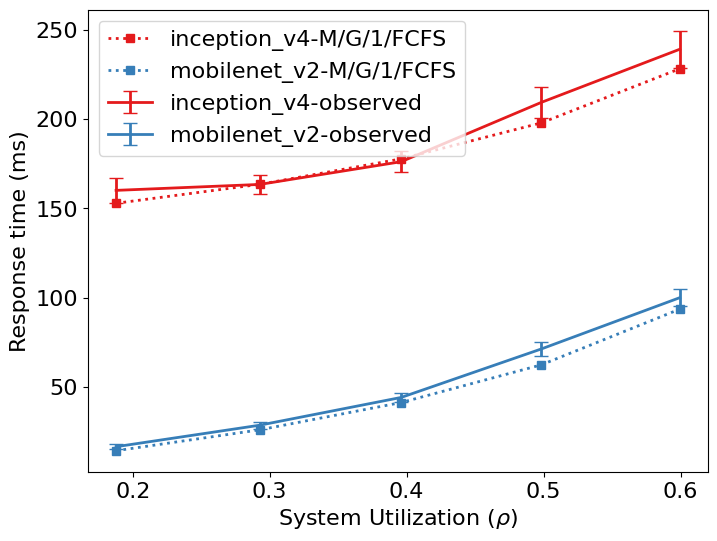

In [13]:
_ = plot_result("../data/queueing_validation/queuing_tpu_inception_v4Xmobilenet_v2.csv", "", True, False)

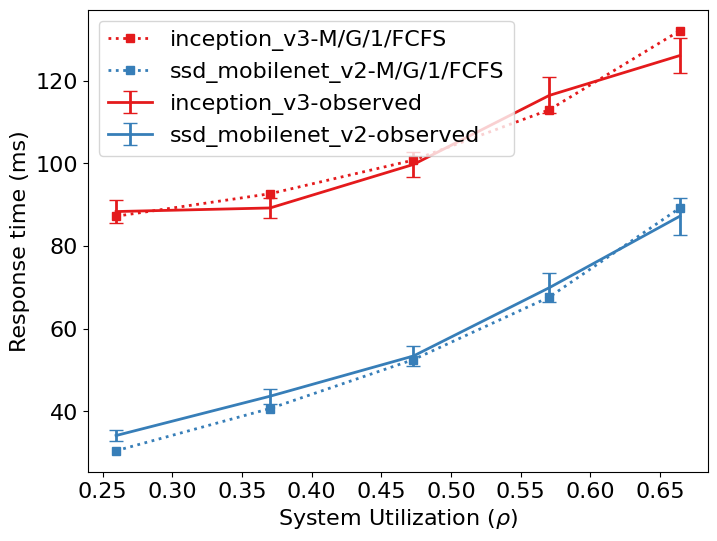

In [15]:
_ = plot_result("../data/queueing_validation/queuing_tpu_inception_v3Xssd_mobilenet_v2.csv", "", True, False)

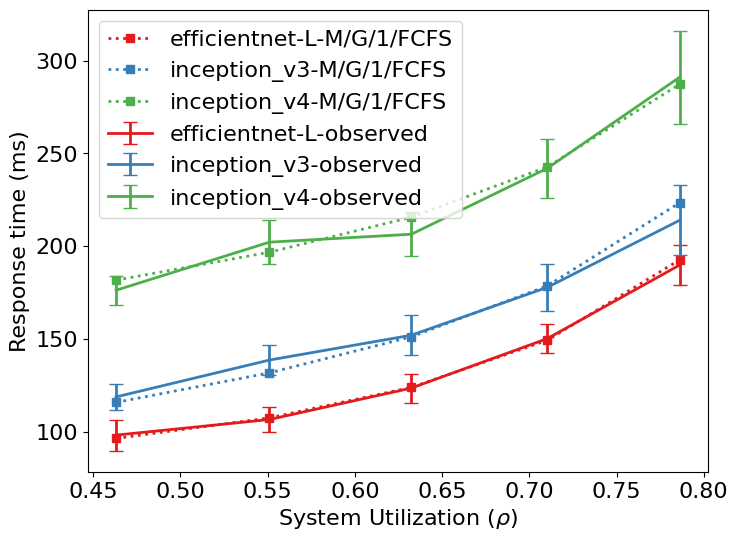

In [16]:
_ = plot_result("../data/queueing_validation/queuing_tpu_efficientnet-LXinception_v3Xinception_v4.csv", "", True, False)